In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pathlib
import time
import random
import torchvision.models as models
import torch.nn as nn
# from pytorchtools import EarlyStopping

# !pip install torch pytorch-lightning
# !pip install git+https://github.com/PyTorchLightning/pytorch-lightning
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

!pip install git+https://github.com/ncullen93/torchsample

from torchsample.modules import ModuleTrainer




# import torchvision.datasets as datasets

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.optim as optim
from torch.optim import Adam, SGD

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-pzb22p6k
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-pzb22p6k


In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# from google.colab import folder
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/data/'

os.listdir(root_path)

Mounted at /content/gdrive


['test_data', 'val_data', 'train_data']

In [ ]:


train_transformer=transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        # [0.5,0.5,0.5])
])


train_path='gdrive/My Drive/data10/train_data'
val_path='gdrive/My Drive/data10/val_data'
test_path='gdrive/My Drive/data10/test_data'

train_loader=DataLoader(
    ImageFolder(train_path,transform=train_transformer),
    batch_size=32, shuffle=True
)

#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['n000003', 'n000010', 'n000011', 'n000013', 'n000015', 'n000017', 'n000018', 'n000020', 'n000023', 'n000024']


In [ ]:
# mean = ImageFolder(test_path,transform=test_transformer).float().mean() / 255
# std = train_data.data.float().std() / 255

mean = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(train_loader.dataset)

var = 0.0
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(train_loader.dataset)*64*64))


In [ ]:
# print(type(ImageFolder(test_path,transform=test_transformer)))
print(mean)

tensor([0.5025, 0.4218, 0.3816])


In [ ]:
train_transformer=transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    # transforms.LinearTransformation(mean_vector=mean),
    transforms.Normalize(mean, 
                        [1,1,1]) #to make the data zero-centric by substracting from the mean and deviding by one
])

test_transformer = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [1, 1, 1])
                                     ])

train_loader=DataLoader(
    ImageFolder(train_path,transform=train_transformer),
    batch_size=32, shuffle=True
)

val_loader=DataLoader(
    ImageFolder(val_path,transform=train_transformer),
    batch_size=32, shuffle=False
)

test_loader=DataLoader(
    ImageFolder(test_path,transform=train_transformer),
    batch_size=32, shuffle=False
)


In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=7, stride=1),
            ReLU(inplace=True),
            Conv2d(32, 16, kernel_size=7, stride=1),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 16, kernel_size=(5, 6), stride=1, padding=1),
            ReLU(inplace=True),
            Dropout(0.5),
            Conv2d(16, 16, 5, stride=1),
            BatchNorm2d(16),
            ReLU(inplace=True),

        )

        self.linear_layers = Sequential(
            Linear(6080, len(classes)) 
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x2 = x
        x = self.linear_layers(x)
        return x

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
model=Net().to(device)

In [ ]:
loss_function=CrossEntropyLoss()
loss_function = loss_function.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


def train(model, data_iterator, optimizer, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in data_iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = loss_function(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     
    
    return avg_loss, avg_acc



def evaluate(model, data_iterator, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in data_iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_function(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     

    return avg_loss, avg_acc



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




def plot_curves(a, b, label):
    plt.figure(1)
    plt.plot(a, 'b', label="train")
    plt.plot(b, 'g', label="valid")
    plt.title('Training/Valid ' + label)
    plt.legend()
    plt.show()




def main(model, train_iterator, optimizer, loss_function, device, scheduler=None, EPOCHS=3):
  #EPOCHS = 10

  train_loss_all = []
  valid_loss_all = []

  train_acc_all = []
  valid_acc_all = []
  # test_acc_all = []

  # early_stopping = EarlyStopping(monitor='accuracy', patience=30, verbose=True)

  for epoch in range(EPOCHS):
      
      start_time = time.monotonic()
      
      train_loss, train_acc = train(model, train_iterator, optimizer, loss_function , device)
      valid_loss, valid_acc = evaluate(model, val_loader, loss_function, device)
      # test_loss, test_acc = evaluate(model, test_loader, loss_function, device)
      if not scheduler is None:
        scheduler.step()

      train_loss_all.append(train_loss)
      valid_loss_all.append(valid_loss)
      # test_loss_all.append(test_loss)

      train_acc_all.append(train_acc)
      valid_acc_all.append(valid_acc)
      # test_acc_all.append(test_acc)

      
      end_time = time.monotonic()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
      # print(f'\t Test. Loss: {Test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

      # early_stopping(valid_acc, model)
      # if early_stopping.early_stop:
      #       print("Early stopping")
      #       break

  plot_curves(train_loss_all, valid_loss_all, 'loss')
  plot_curves(train_acc_all, valid_acc_all, 'accuracy')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 2.153 | Train Acc: 24.42%
	 Val. Loss: 2.241 |  Val. Acc: 35.00%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.807 | Train Acc: 37.70%
	 Val. Loss: 1.916 |  Val. Acc: 45.00%
Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.512 | Train Acc: 49.15%
	 Val. Loss: 1.606 |  Val. Acc: 50.00%
Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.350 | Train Acc: 55.38%
	 Val. Loss: 1.729 |  Val. Acc: 45.00%
Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.193 | Train Acc: 61.49%
	 Val. Loss: 1.558 |  Val. Acc: 50.00%
Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 1.093 | Train Acc: 62.24%
	 Val. Loss: 1.834 |  Val. Acc: 50.00%
Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 1.000 | Train Acc: 68.92%
	 Val. Loss: 1.541 |  Val. Acc: 45.00%
Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.914 | Train Acc: 70.03%
	 Val. Loss: 1.344 |  Val. Acc: 55.00%
Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.866 | Train Acc: 72.55%
	 Val. Loss: 1.321 |  Val. Acc: 55.00%
Epoch: 10 | Epoch T

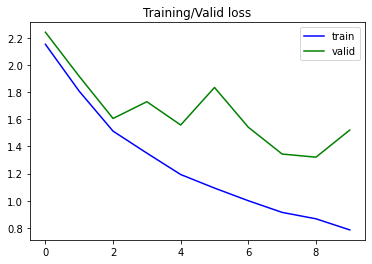

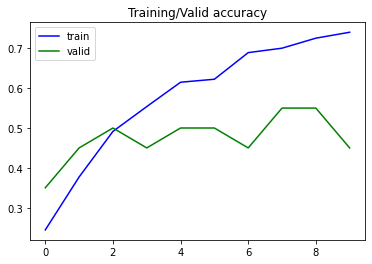

In [ ]:
model = model.to(device)
optimizer2 = SGD(model.parameters(), lr=0.008, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, gamma=0.005, step_size=33)
EPOCHS = 10
main(model, train_loader, optimizer2, loss_function, device, scheduler, EPOCHS)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 14s
	Train Loss: 2.143 | Train Acc: 24.74%
	 Val. Loss: 2.205 |  Val. Acc: 40.00%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 1.805 | Train Acc: 39.33%
	 Val. Loss: 1.927 |  Val. Acc: 40.00%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 1.604 | Train Acc: 47.39%
	 Val. Loss: 1.645 |  Val. Acc: 55.00%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 1.472 | Train Acc: 53.92%
	 Val. Loss: 1.418 |  Val. Acc: 50.00%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 1.353 | Train Acc: 56.56%
	 Val. Loss: 1.378 |  Val. Acc: 55.00%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 1.276 | Train Acc: 58.49%
	 Val. Loss: 1.336 |  Val. Acc: 55.00%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 1.200 | Train Acc: 60.48%
	 Val. Loss: 1.320 |  Val. Acc: 55.00%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 1.134 | Train Acc: 62.43%
	 Val. Loss: 1.327 |  Val. Acc: 50.00%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.079 | Train Acc: 65.41%
	 Val. Loss: 1.226 |  Val. Acc: 55.00%
Epoch: 10 | Epoch T

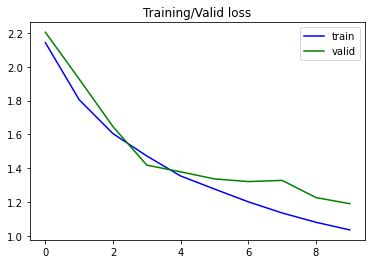

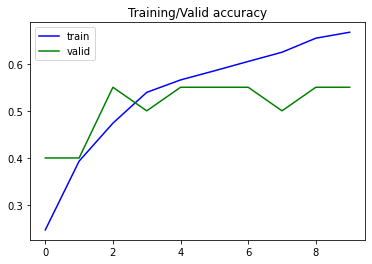

In [ ]:
model = model.to(device)
optimizer3 = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer3, gamma=0.005, step_size=33)
EPOCHS = 10
main(model, train_loader, optimizer3, loss_function, device, scheduler, EPOCHS)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 22.646 | Train Acc: 17.42%
	 Val. Loss: 2.294 |  Val. Acc: 20.00%
Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 2.223 | Train Acc: 22.52%
	 Val. Loss: 2.221 |  Val. Acc: 20.00%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 2.075 | Train Acc: 27.53%
	 Val. Loss: 2.095 |  Val. Acc: 25.00%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 2.049 | Train Acc: 28.40%
	 Val. Loss: 2.081 |  Val. Acc: 30.00%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 1.956 | Train Acc: 30.42%
	 Val. Loss: 1.987 |  Val. Acc: 30.00%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 1.906 | Train Acc: 33.34%
	 Val. Loss: 2.049 |  Val. Acc: 25.00%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 1.863 | Train Acc: 35.32%
	 Val. Loss: 2.035 |  Val. Acc: 30.00%
Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 1.815 | Train Acc: 34.20%
	 Val. Loss: 1.836 |  Val. Acc: 35.00%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.770 | Train Acc: 37.41%
	 Val. Loss: 1.953 |  Val. Acc: 40.00%
Epoch: 10 | Epoch 

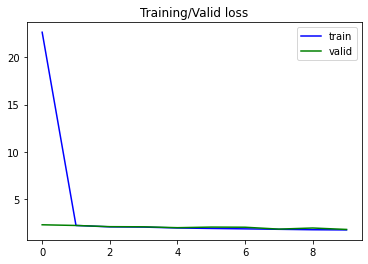

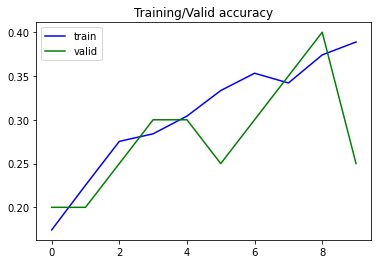

In [ ]:
model = model.to(device)
optimizer4 = optim.RMSprop(model.parameters(), lr=0.008, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer4, gamma=0.005, step_size=33)
EPOCHS = 10
main(model, train_loader, optimizer4, loss_function, device, scheduler, EPOCHS)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 2.356 | Train Acc: 23.33%
	 Val. Loss: 1.941 |  Val. Acc: 35.00%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 1.727 | Train Acc: 43.20%
	 Val. Loss: 1.473 |  Val. Acc: 50.00%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 1.343 | Train Acc: 54.68%
	 Val. Loss: 1.317 |  Val. Acc: 50.00%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 1.099 | Train Acc: 62.98%
	 Val. Loss: 1.449 |  Val. Acc: 45.00%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.990 | Train Acc: 66.17%
	 Val. Loss: 1.225 |  Val. Acc: 50.00%
Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.783 | Train Acc: 72.30%
	 Val. Loss: 1.246 |  Val. Acc: 55.00%
Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.642 | Train Acc: 79.28%
	 Val. Loss: 1.128 |  Val. Acc: 65.00%
Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.485 | Train Acc: 84.58%
	 Val. Loss: 1.244 |  Val. Acc: 55.00%
Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.398 | Train Acc: 88.72%
	 Val. Loss: 0.941 |  Val. Acc: 60.00%
Epoch: 10 | Epoch Time: 0m 

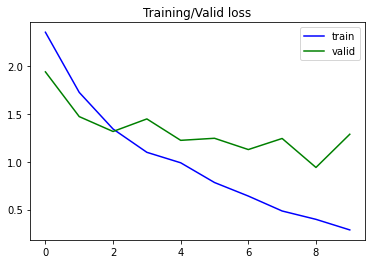

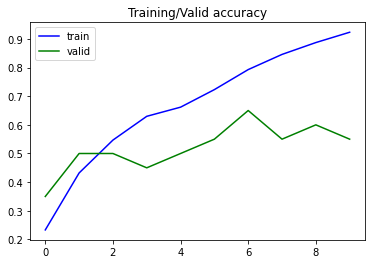

In [ ]:
optimizer=Adam(model.parameters(),lr=0.001, weight_decay=0.0001)
EPOCHS = 10
main(model, train_loader, optimizer, loss_function, device, None, EPOCHS)

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, loss_function, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.047 | Test Acc: 75.00%


In [ ]:
class Improved_Net(Module):   
    def __init__(self):
        super(Improved_Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 32, kernel_size=7, stride=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Conv2d(32, 16, kernel_size=7, stride=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 16, kernel_size=(5, 6), stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            Dropout(0.5),
            Conv2d(16, 16, 5, stride=1),
            BatchNorm2d(16),
            ReLU(inplace=True),

        )

        self.linear_layers = Sequential(
            Linear(6080, len(classes)) 
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x2 = x
        x = self.linear_layers(x)
        return x

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 2.145 | Train Acc: 30.18%
	 Val. Loss: 1.947 |  Val. Acc: 55.00%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 1.425 | Train Acc: 53.31%
	 Val. Loss: 1.335 |  Val. Acc: 55.00%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 1.095 | Train Acc: 63.81%
	 Val. Loss: 1.405 |  Val. Acc: 55.00%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.908 | Train Acc: 67.02%
	 Val. Loss: 1.316 |  Val. Acc: 55.00%
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 0.704 | Train Acc: 76.85%
	 Val. Loss: 1.260 |  Val. Acc: 55.00%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.492 | Train Acc: 84.91%
	 Val. Loss: 1.296 |  Val. Acc: 55.00%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.399 | Train Acc: 87.27%
	 Val. Loss: 1.165 |  Val. Acc: 70.00%
Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.317 | Train Acc: 91.70%
	 Val. Loss: 0.845 |  Val. Acc: 60.00%
Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 0.226 | Train Acc: 94.19%
	 Val. Loss: 0.952 |  Val. Acc: 60.00%
Epoch: 10 | Epoch T

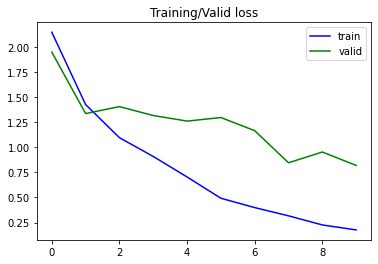

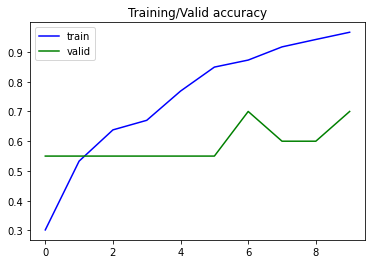

In [ ]:
improved_model=Improved_Net().to(device)
optimizer=Adam(improved_model.parameters(),lr=0.001, weight_decay=0.0001)
EPOCHS = 10
main(improved_model, train_loader, optimizer, loss_function, device, None, EPOCHS)

In [ ]:
test_loss, test_acc = evaluate(improved_model, test_loader, loss_function, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.748 | Test Acc: 85.00%


In [ ]:
model_ft = models.vgg16(pretrained=True)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# model_ft.layers[:15]

ct = 0
ct2 = 0
for child in model_ft.children():
  # print(child)
  ct += 1
  if ct == 3:
    # print(child)
    for param in child.parameters():
      ct2 +=1
      if ct > 1:
        param.requires_grad = False
        # print(param.requires_grad)
    # print(child)

# model_ft.classifier = model_ft.classifier[0]
# model_ft.classifier[1] = model_ft.classifier

# model_ft.classifier[0] = nn.Linear(4096, 234)
model_ft.classifier = model_ft.classifier[0:2]
model_ft.classifier[1] = Linear(4096, len(classes))
print(model_ft)

# optimizer = Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.001)


# print(model_ft.children)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 2m 3s
	Train Loss: 2.407 | Train Acc: 17.30%
	 Val. Loss: 2.355 |  Val. Acc: 10.00%
Epoch: 02 | Epoch Time: 1m 55s
	Train Loss: 2.248 | Train Acc: 16.53%
	 Val. Loss: 2.363 |  Val. Acc: 10.00%
Epoch: 03 | Epoch Time: 1m 54s
	Train Loss: 2.265 | Train Acc: 13.67%
	 Val. Loss: 2.342 |  Val. Acc: 10.00%
Epoch: 04 | Epoch Time: 1m 52s
	Train Loss: 2.236 | Train Acc: 14.10%
	 Val. Loss: 2.393 |  Val. Acc: 10.00%
Epoch: 05 | Epoch Time: 1m 51s
	Train Loss: 2.166 | Train Acc: 20.28%
	 Val. Loss: 3.121 |  Val. Acc: 15.00%
Epoch: 06 | Epoch Time: 1m 53s
	Train Loss: 2.282 | Train Acc: 15.73%
	 Val. Loss: 2.319 |  Val. Acc: 10.00%
Epoch: 07 | Epoch Time: 1m 54s
	Train Loss: 2.142 | Train Acc: 20.09%
	 Val. Loss: 2.291 |  Val. Acc: 25.00%
Epoch: 08 | Epoch Time: 1m 53s
	Train Loss: 1.949 | Train Acc: 27.97%
	 Val. Loss: 2.081 |  Val. Acc: 30.00%
Epoch: 09 | Epoch Time: 1m 52s
	Train Loss: 1.832 | Train Acc: 31.90%
	 Val. Loss: 2.066 |  Val. Acc: 15.00%
Epoch: 10 | Epoch Ti

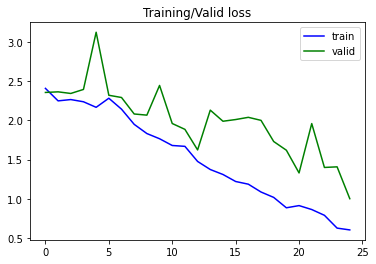

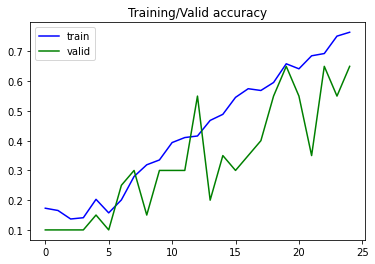

In [ ]:
optimizer=Adam(model_ft.parameters(),lr=0.001, weight_decay=0.0001)
EPOCHS = 25
main(model_ft, train_loader, optimizer, loss_function, device, None, EPOCHS)

**Report**

- part-1
 - Data has been processed to be made zero-centered
 - Traning data has been taken from the train_data file, and tha validation data has been taken from the val_data file
 - The propoced model has been implemented and the last layer (softMax) has been added by CrossEntropy functoin 
  - Babysetting has been applied (hyperparameter, learning rates, regularization, ...) and for the architecture the relu function was added after each Conv2d layer (it wasn't required in the given architecture)
  - All the required optimizers have been tried and reported, the selected one was Adam (the most desired results)
  - Train, val and test data all have been reported as required 
  - One of the changes applied that can improve the model in my result is to add batchNormalization (more than one) as has been implented and reported  

- Part -2
  - Transfare learning has been implemented and reported as required